#  카메라 스티커앱 만들기 첫걸음

이번 코스를 통해
1. 카메라앱 만들기를 통해 **동영상 처리, 검출, 키포인트 추정, 추적, 카메라 원근**의 기술을 다룬다.
2. 간단한 스티커부터 시작해서 각도 변화가 가능하고 거리변화에 robust한 스티커까지 만들 수 있다.

학습 목표
1. 얼굴인식 카메라의 흐름 이해
2. dlib 라이브러리 사용
3. 이미지 배열의 인덱싱 예외 처리


#  어떻게 만들까? 사진 준비하기

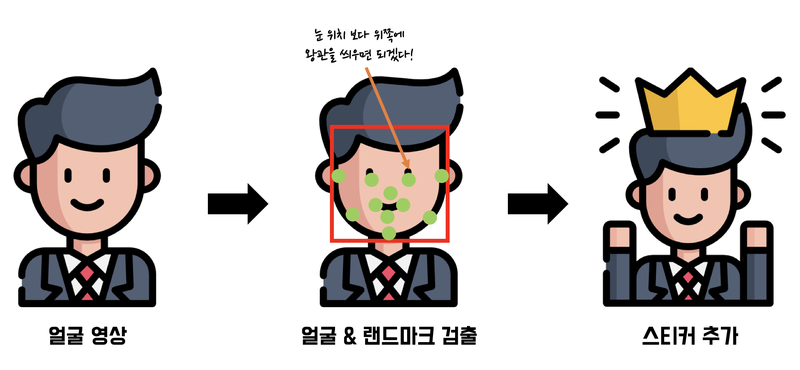

스티커를 세밀하고 자연스럽게 적용하려면, 얼굴 각각의 위치를 아는 게 중요하다. 이 기술을 `landmark` 또는 `alignment`라고 한다.
더 큰 범위로는 `keypoint detection`이라고도 부른다.

대부분의 face landmark 데이터셋은 눈, 코, 입, 턱을 포함한다.


In [41]:
# import module
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

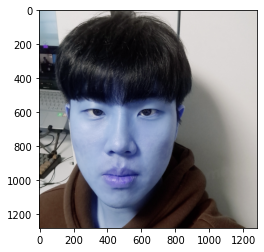

In [42]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png' #원하는 이미지 경로를 지정한다
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다(절대/상대 경로 모두 가능)
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()


show를 해보면, 이미지 색이 푸른빛이 돈다. 이는 opencv의 특징 때문이다.
이번 코스에서 사용한 matplotlib, dlib등의 이미지 라이브러리는 모두 이미지 채널을 RGB로 사용하지만, opencv는 BRG를 사용한다.

그래서 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 보인다.

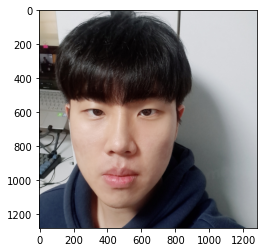

In [43]:
#plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # 색을 바꿔줌
plt.imshow(img_rgb)
plt.show()


#  얼굴 검출 face detection

detection 기술을 이용해 얼굴 위치를 찾아보자.
dlibb의 `face detector`는 HOG(Histrogram of Oriented Gradientss)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾는다.
HOG는 이미지에서 생각의 변화량을 나타낸다. 이미지로부터 특징만 잘 잡아낸다. 2000년 초반에 모두 이 방식이 응용되었다.


1. HOG
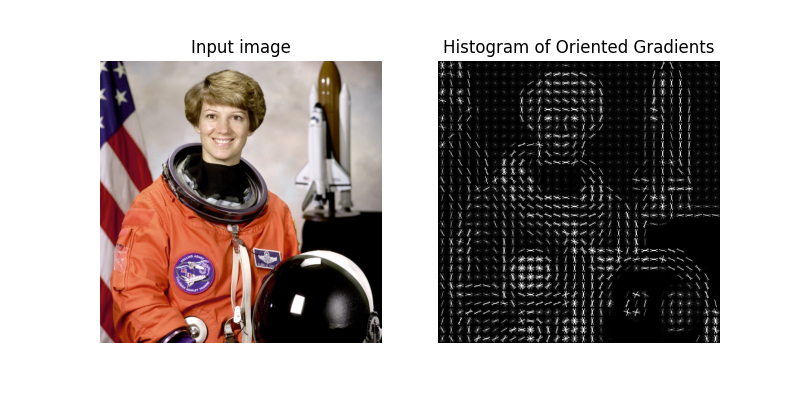
https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

2. SVM
SVM은 선형 분류기이다. 한 이미지를 다차원 공간의 한 벡터라고 보면, 여러 이미지는 여러 벡터가 될 것이다. SVM은 이 벡터들을 잘 구분짓는 방법이다. 여기서는 얼굴이냐 아니냐를 구분해 줄 것이다.

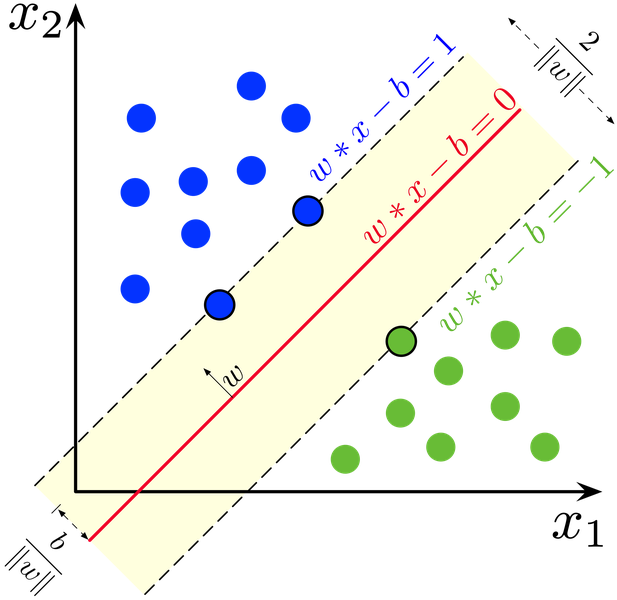
https://en.wikipedia.org/wiki/Support-vector_machine

하지만, 이미지의 색상만 가지고는 SVM이 큰 힘을 발휘하지 못한다. 하지만 이미지가 HOG를 통해 벡터로 만들어진다면 SVM이 잘 작동한다.

그렇다면 얼굴의 위치는 어떻게 찾을까? 바로 sliding window를 사용한다. slidinig window란 작은 영역(window)을 이동해가며 확인하는 방법을 말한다. 하지만, 이미지가 클수록 시간이 오래걸리는 단점이 있다.


In [44]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()

`detector_hog`를 이용해서 얼굴의 bounding box를 추출한다.

In [45]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

dlib은 rgb 이미지를 입력으로 받으므로, `cvtColor()`를 이용해서 rgb 이미지로 변환한다. 

`detector_hog`의 두 번째 파라미터는 이미지 피라미드의 수이다. 이미지 피라미드는 이미지를 upsampling 방법을 통해 크기를 키우는 방법을 말한다.   
이미지 피라미드에서 얼굴을 다시 검출하면, 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능하다.

- upsmapling이란,   
간단하게 데이터의 크기를 키워주는 방법이다. 일반적으로 CNN의 레이어를 통과하면서 이미지의 크기를 줄이는 것을 down sampling이라고 하는데, down sampling의 반대 개념이 upsampling인 셈이다.

찾은 얼굴을 출력해보자.

rectangles[[(132, 428) (798, 1094)]]


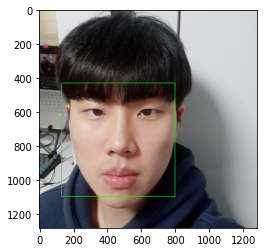

In [46]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), thickness =2, lineType=cv2.LINE_AA)
    # cv2.rectangle(img=cv2_im, pt1=a, pt2=b, color=(0, 255, 0), thickness=3, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


dlib detector는 `dlib.rectangles`타입의 객체를 반환한다. `dlib.rectangles`는 `dlib.rectangle` 객체의 배열 형태로 이뤄져 있다.

`dlib.rectangle`객체는 `left(), top(), right(), bottom(), height(), width()` 등의 멤버 함수를 포함하고 있다.

#  얼굴 랜드마크 face landmark

앞서와 같이 스티커를 섬세하게 적용하기 위해서는 이목구비의 위치를 아는 것이 중요하다. 이목구비의 위치를 추론하는 기술을 _face landmark locaization_ 기술이라고 한다. face landmark는 detection의 결과물인 bounding box로 잘라낸 얼굴 이미지를 이용한다.

**Object keypoin estimation** 알고리즘
Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 한다. keypoint를 찾는 알고리즘은 크게 2가지로 나눠진다.
1. top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2. bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성   

이번 예제에서는 1번 방식을 다룬다.


### 1) Dlib landmark localization

잘라진 얼굴 이미지에서 아래 68개의 이목구비 위치를 찾는다.

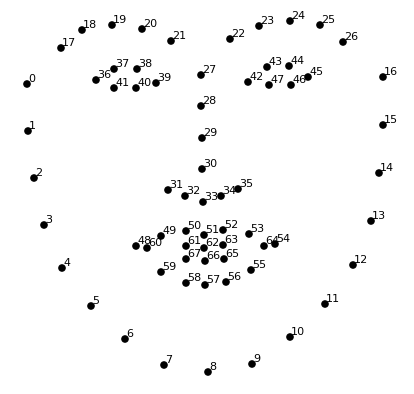

Dlib은 ibug 300-W 데이터셋으로 학습한 pretrained model 을 제공한다. 학습 알고리즘은 regression tree의 앙상블 모델.

먼저 Dlib의 제공되는 모델을 사용해보자. 먼저 공개된 weight file을 다운로드 받자. 해당 모델파일은 bz2 압축파일 형태로 제공되어 압축을 풀어준 후 사용하자.

```
$ wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
$ mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models
$ cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2
```

이후 저장한 landmark 모델을 불러오자.

In [47]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("done")

done


`landmark_predictor`는 `RGB` 이미지와 `dlib.rectangle`을 입력 받아 `dlib.full_object_detection` 를 반환한다.

In [74]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아낸다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect) # rgb image, rectangle
    # 68개의 face landmark 좌표를 저장한다.
    
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


`point`는 `dlib.full_object_detection`의 객체이기 때문에, `parts()`함수로 개별 위치에 접근할 수 있다. 조금 더 직관적인 (x,y) 형태로 접근할 수 있도록 변환해 주었다. 따라서 `list_points`는 tuple(x,y) 68개로 이뤄진 리스트가 된다. 이미지에서 찾은 얼굴 개수마다 반복하면 `list_lnadmark`에 68개의 랜드마크가 얼굴 개수만큼 저장된다.

랜드마크를 영상에 출력해보자.

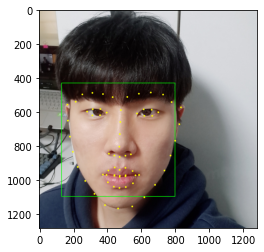

In [49]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 5, (0, 255, 255), -1)
        # cv2.circle(img, center, radius, color, thickness=None, lineType=None, shift=None) -> img
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# 스티커 적용하기

이제 스티커를 머리에 씌워보자. 눈썹 위 중앙에 씌우면 될 것 같다. 구현 방법은 여러 가지가 있다. 중요한 것은 얼굴 위치, `카메라의 거리에 따라 픽셀 x`가 다르기 때문에 `비율로 계산`을 해줘야 한다. 계산할 수치는 두 가지이다.

1. 스티커 위치
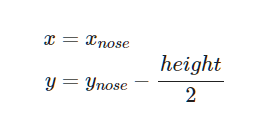

2. 스티커 크기
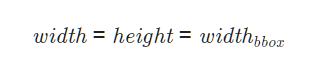

좌표를 확인해보자.

In [50]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(471, 802)
(x,y) : (471,469)
(w,h) : (667,667)


준비한 스티커 이미지를 읽어서 적용해보자.

In [51]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 resize
print (img_sticker.shape)

(667, 667, 3)


원본 이미지에 스티커 이미지를 추가하기 위해 x,y 좌표를 조정하자. 이미지 시작점은 top-left이다.

In [52]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (138,-198)


y값이 음수가 나오는데, 이는 이미지 범위 밖까지 스티커가 벗어났음을 의미한다. 그런데 opencv 데이터는 numpy ndarray형태의 데이터를 사용하기 때문한다. 하지만 ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대해 예외처리를 해 주어야 한다.

또한, 스티커가 원본 이미지의 범위를 넘어가는 경우가 하나 더 있는데,  이는 `스티커의 시작점+스티커 사진`의 크기가 원본 이미지의 크기보다 큰 경우다. 스티커 사진의 오른쪽이나 아래쪽으로 넘어가는 경우이다.


In [53]:
'''
plt.subplot(2,1,1)
plt.imshow(img_sticker)
'''

if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

'''
plt.subplot(2,1,2)
plt.imshow(img_sticker)

plt.show()
'''
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (138,0)


`- y` 크기만큼 스티커를 crop하고, top의 x좌표와 y좌표를 각각에 맞춰 원본 이미지의 경계값으로 수정하면 위와 같은 형식으로 나온다.

이제 원본 이미지에 스티커를 적용해보자.

In [72]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
# img_sticker이 0이면 img_sticker값을 위치시키고, 그게 아니라면 sticker_area의 값을 위치시켜라

print("Done")

Done


`sticker_area`는 원본 이미지에서 스티커를 적용할 위치를 crop한 이미지이다. 예제에서는 (344,0)부터 (344+187, 0+89)범위의 이미지를 의미한다.

스티커 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용한다. 따라서 `np.where`를 통해 `img_sticker`가 0인 부분은 `sticker_area`를 사용하고 0이 아닌 부분을 `img_sticker`를 사용하면 된다.
`img_show`에 다시 적용하자.

#### 코드 이해하는 데 추가로 도움이 될 것 
- [참고 링크](https://shate-programming.tistory.com/26)
- 여기서 체크할 점은, 포토샵 프로그램처럼 원본 이미지 위에 스티커 이미지를 붙여넣는 게 아니라, **sticker_area에서 img_sticker의 픽셀값으로 변경해주는 것이다.**
원본 이미지의 픽셀값이 바뀌어서 '원본 이미지와 스티커 이미지가 합쳐진 것'처럼 보이는 것이다!!
- 스티커 이미지로 원본 이미지를 대체하게 되면, 원본 이미지의 필요한 부분이 가려지게 된다.


결과를 출력하면, 스티커 기본 기능이 완성되었다!

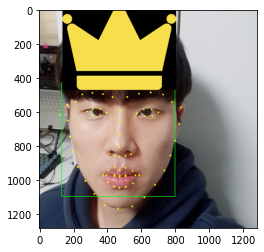

In [73]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

스티커 기본 기능이 완성되었다.

bounding box와 landmark를 제거하고 최종 결과만 출력해보자. `img_show`대신 `img_rgb`를 활용하자.

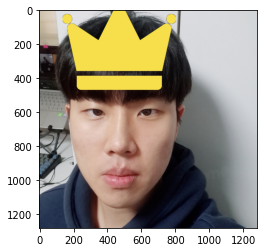

In [56]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()